# Xai Project: Evaluating Explainability
In this work we fine-tuned ResNet-18 for a binary task, exploiting the "Cats and Dogs" image classification dataset. We then evaluated a set of explainability methods using the Captum library. We will use primarly Grounded SAM model to segment the image and extract the patches of each image.

In [74]:
from datetime import datetime
# Enable it for DEMO
import warnings
warnings.filterwarnings("ignore")
start_notebook_time = datetime.now() #for time lenght of the whole notebook

In [75]:
!pip install captum
!pip install autodistill-grounded-sam autodistill-yolov8
!pip install roboflow

In [76]:
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology
from autodistill.utils import plot

parts = ["head", "body", "tail", "ear", "eye", "nose", "mouth", "paw"]


# Class-specific ontologies
ontology_dog = CaptionOntology({f"dog {part}": part for part in parts})
ontology_cat = CaptionOntology({f"cat {part}": part for part in parts})

# Pre-initialize both models
sam_dog = GroundedSAM(ontology=ontology_dog)
sam_cat = GroundedSAM(ontology=ontology_cat)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


# Instance to be explained 

In [77]:
# Opzione 1: Choose the paath
image_path = "/kaggle/input/cats-and-dogs-image-classification/test/cats/cat_106.jpg"

# Opzione 2: Choose the datatset index
use_index = False
image_index = 5 

In [78]:
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset, DataLoader, Subset
import torch
import os
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("/kaggle/input/pre-computations/best_model.pth", map_location=device))
model = model.to(device)
model.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


if use_index:
    image, label = test_dataset[image_index]
    image_path = test_dataset.samples[image_index][0]
else:
    from PIL import Image as PILImage
    image = PILImage.open(image_path).convert("RGB")
    image = transform(image)  # stessa transform usata nel dataset
    label = -1  # ignora label se non nota

image = image.unsqueeze(0).to(device)

with torch.no_grad():
    original_pred = model(image)

predicted_class = original_pred.argmax(dim=1).item()
original_prob = torch.softmax(original_pred, dim=1)[0, predicted_class].item()
assigned_label = "cat" if predicted_class == 0 else "dog"
medoid_class = "cat" if assigned_label == "dog" else "dog"

print(f"Predicted class: {assigned_label} (prob = {original_prob:.4f})")

Predicted class: cat (prob = 0.9999)


## Import Medoid

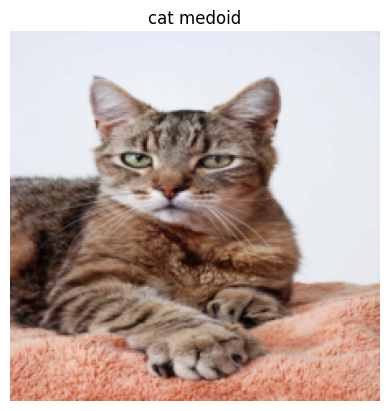

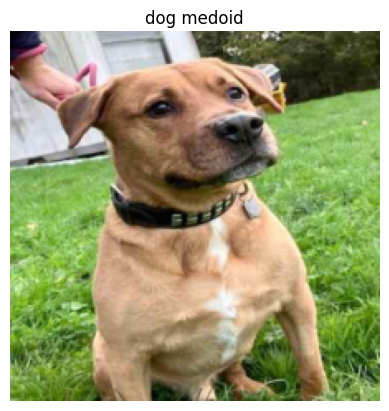

In [79]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision.datasets import CIFAR10

for img_path in ["/kaggle/input/pre-computations/medoid_class_0.png", "/kaggle/input/pre-computations/medoid_class_1.png"]:
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    title_str = "cat medoid" if "0" in img_path else "dog medoid"
    plt.title(f"{title_str}")
    plt.axis("off")
    plt.show()

## Gradient-based methods
We adopted Captum as a library to explain the model.

In [80]:
from captum.attr import IntegratedGradients, Saliency, Occlusion, LayerGradCam, InputXGradient, GuidedBackprop
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

#Traform in numpy image 
def unnormalize(img_tensor, mean, std):
    if isinstance(mean, torch.Tensor):
        mean = mean.tolist()
    if isinstance(std, torch.Tensor):
        std = std.tolist()

    img = img_tensor.clone().detach().cpu().numpy()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return np.clip(img.transpose(1, 2, 0), 0, 1)

def compute_gradient_methods(model, image, predicted_class, show=False, use_absolute=False):
    attributions_gray = {}
    timings = {}

    input_tensor = image.to(device)
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    
    orig_np = unnormalize(image.squeeze(0), mean, std)

    # GradCAM layer (last ResNet block)
    gradcam_layer = model.layer4[-1]

    #  GuidedBackprop (per Guided GradCAM) 
    start_guided = time.time()
    guided_bp = GuidedBackprop(model).attribute(input_tensor, target=predicted_class)

    #  GradCAM 
    start = time.time()
    layer_gc = LayerGradCam(model, gradcam_layer).attribute(input_tensor, target=predicted_class)
    timings["GradCAM"] = time.time() - start

    #  Upsample + Guided GradCAM 
    # Upsample GradCAM to match GuidedBackprop (3 channels)
    layer_gc_upsampled = torch.nn.functional.interpolate(
        layer_gc, size=(224, 224), mode='bilinear', align_corners=False
    )
    
    # Repeat to match the 3 channels of GuidedBackprop
    layer_gc_upsampled = layer_gc_upsampled.repeat(1, 3, 1, 1)

    guided_gradcam = guided_bp * layer_gc_upsampled
    timings["Guided GradCAM"] = time.time() - start_guided

    # Altri metodi 
    methods = {}

    start = time.time()
    methods["Integrated Gradients"] = IntegratedGradients(model).attribute(input_tensor, target=predicted_class, n_steps=200)
    timings["Integrated Gradients"] = time.time() - start

    start = time.time()
    methods["Saliency"] = Saliency(model).attribute(input_tensor, target=predicted_class)
    timings["Saliency"] = time.time() - start

    start = time.time()
    methods["Occlusion"] = Occlusion(model).attribute(
        input_tensor, strides=(1, 3, 3), target=predicted_class,
        sliding_window_shapes=(1, 15, 15), baselines=0)
    timings["Occlusion"] = time.time() - start

    start = time.time()
    methods["Input × Gradient"] = InputXGradient(model).attribute(input_tensor, target=predicted_class)
    timings["Input × Gradient"] = time.time() - start

    methods["GradCAM"] = layer_gc
    methods["Guided GradCAM"] = guided_gradcam

    # Visualizzation 
    if show:
        fig, axs = plt.subplots(1, len(methods) + 1, figsize=(15, 5))
        axs[0].imshow(orig_np)
        axs[0].set_title("Original")
        axs[0].axis("off")

    for i, (name, attr) in enumerate(methods.items(), start=1):
        attr_np = attr.squeeze().detach().cpu().numpy()
        
        if attr_np.ndim == 3:
            attr_gray = np.sum(attr_np, axis=0) if not use_absolute else np.sum(np.abs(attr_np), axis=0)
        else:
            attr_gray = attr_np if not use_absolute else np.abs(attr_np)

        attr_vis = (attr_gray - attr_gray.min()) / (attr_gray.max() - attr_gray.min() + 1e-8)
        attributions_gray[name] = attr_gray

        if show:
            axs[i].imshow(orig_np, alpha=0.3)
            axs[i].imshow(attr_gray, cmap="seismic", alpha=0.7, vmin=-np.max(np.abs(attr_gray)), vmax=np.max(np.abs(attr_gray)))
            axs[i].set_title(name)
            axs[i].axis("off")

    if show:
        plt.tight_layout()
        plt.show()

    return attributions_gray, timings

## LIME computation

In [81]:
import numpy as np
from skimage.segmentation import mark_boundaries
from captum._utils.models.linear_model import SkLearnLinearRegression
from captum.attr import Lime
from captum.attr import visualization as viz
import torch
import matplotlib.pyplot as plt

def compute_LIME(model, image_to_explain, class_predicted, feature_masks, show=False, use_absolute=False): 

    unnormalize = T.Normalize(mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])],std=[1/s for s in [0.229, 0.224, 0.225]])
    orig_np = unnormalize(image_to_explain[0]).permute(1, 2, 0).cpu().numpy()
    orig_np = np.clip(orig_np, 0, 1)
    
    # 1. Construct feature_masks from Grounded-SAM
    H, W = feature_masks[0].shape
    feature_mask = np.zeros((H, W), dtype=np.int32)
    
    for idx, mask in enumerate(feature_masks):
        feature_mask[mask] = idx + 1  # background resta 0
    
    # Resize feature_mask a 224x224 to matchare orig_np
    feature_mask_resized = cv2.resize(feature_mask, (224, 224), interpolation=cv2.INTER_NEAREST)
    if show:
        # 2. Visualizza masks of Grounded-SAM
        plt.figure(figsize=(6, 6))
        plt.imshow(mark_boundaries(orig_np, feature_mask_resized))
        plt.title("LIME segmentation")
        plt.axis("off")
        plt.show()
        
        print("Feature IDs:", np.unique(feature_mask).tolist())
        print("Feature mask shape:", feature_mask.shape)
        
    # 3.LIME
    lr_lime = Lime(model, interpretable_model=SkLearnLinearRegression())
    
    feature_mask_tensor = torch.tensor(feature_mask_resized).unsqueeze(0).to(device)

    start = time.time()
    lime_attr = lr_lime.attribute(
        image_to_explain,
        target=class_predicted,
        feature_mask=feature_mask_tensor
    ).squeeze(0)
    duration = time.time() - start

    if show:
        # 4. Visualize
        print('Attribution range:', lime_attr.min().item(), 'to', lime_attr.max().item())
        
        _ = viz.visualize_image_attr_multiple(
            lime_attr.permute(1, 2, 0).detach().cpu().numpy(),  # shape [H,W,C]
            orig_np,
            ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
            ["all", "positive", "negative", "positive"],
            titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"])
    

    lime_attr_np = lime_attr.detach().cpu().numpy()
    
    if lime_attr_np.ndim == 3:
        if use_absolute:
            attr_gray = np.sum(np.abs(lime_attr_np), axis=0)
        else:
            attr_gray = np.sum(lime_attr_np, axis=0)
    else:
        attr_gray = np.abs(lime_attr_np) if use_absolute else lime_attr_np
    
    if attr_gray.shape != (224, 224):
        attr_gray = cv2.resize(attr_gray, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    return attr_gray, duration

## SHAP computation

In [82]:
from captum.attr import KernelShap
from skimage.segmentation import mark_boundaries
from captum._utils.models.linear_model import SkLearnLinearRegression
from captum.attr import visualization as viz


def compute_SHAP(model, image_to_explain, class_predicted, feature_masks, show=False, use_absolute=False):
    
    orig_np = unnormalize(image_to_explain[0], mean, std)

    # Costruct feature_masks Grounded-SAM
    H, W = feature_masks[0].shape
    feature_mask = np.zeros((H, W), dtype=np.int32)
    
    for idx, mask in enumerate(feature_masks):
        feature_mask[mask] = idx + 1  # background resta 0
    
    # Resize la feature_mask a 224x224 to matchare orig_np
    feature_mask_resized = cv2.resize(feature_mask, (224, 224), interpolation=cv2.INTER_NEAREST)

    if show:
        # Visualize Grounded-SAM
        plt.figure(figsize=(6, 6))
        plt.imshow(mark_boundaries(orig_np, feature_mask_resized))
        plt.title("Kernel SHAP segmentation")
        plt.axis("off")
        plt.show()
        
    # KernelSHAP 
    ks_model = KernelShap(model)
    
    start = time.time()
    ks_attr = ks_model.attribute(
        image_to_explain,
        target=class_predicted,
        n_samples=100,
        feature_mask=torch.tensor(feature_mask_resized).unsqueeze(0).to(device)
    ).squeeze(0)
    duration = time.time() - start

    if show:
        attr_np = ks_attr.detach().cpu().numpy()
        min_val = attr_np.min()
        max_val = attr_np.max()
        print(f'Attribution range: {min_val:.6f} to {max_val:.6f}')
        
        # Check if the attribution is flat
        if np.abs(max_val - min_val) < 1e-6:
            print("Attribution map is flat (no variation). Skipping visualization.")
        else:
            _ = viz.visualize_image_attr_multiple(
                ks_attr.permute(1, 2, 0).detach().cpu().numpy(),  # shape: [H, W, C]
                orig_np,
                ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
                ["all", "positive", "negative", "positive"],
                titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"]
            )

    
    ks_attr_np = ks_attr.detach().cpu().numpy()
    
    if ks_attr_np.ndim == 3:
        attr_gray = np.sum(ks_attr_np, axis=0) if not use_absolute else np.sum(np.abs(ks_attr_np), axis=0)
    else:
        attr_gray = ks_attr_np if not use_absolute else np.abs(ks_attr_np)

        
    if attr_gray.shape != (224, 224):
        attr_gray = cv2.resize(attr_gray, (224, 224), interpolation=cv2.INTER_LINEAR)
    return attr_gray, duration

## Filtered Masks function

This function selects just the masks that are necessary to maintain the semantics of the image. All the masks are complementary: they do not overlap.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from collections import defaultdict



def show_masks_on_image(base_image, masks, labels, title, label_colors=None):
    H, W = base_image.shape[:2]
    H, W = base_image.shape[:2]
    overlay = np.ones((H, W, 3), dtype=np.uint8) * 255  # sfondo bianco RGB


    for mask, label in zip(masks, labels):
        # Resize of masks to match image dimensions 
        resized_mask = cv2.resize(mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST).astype(bool)
        color = label_colors[label]
        for c in range(3):
            overlay[:, :, c][resized_mask] = color[c]

    plt.imshow(overlay.astype(np.uint8))
    plt.axis("off")
    plt.title(title)
    plt.show()

def show_masks_individually(masks, labels, title_prefix="", id_to_label=None, label_colors=None):
    H, W = image_rgb.shape[:2]

    for i, (mask, label) in enumerate(zip(masks, labels)):
        resized = cv2.resize(mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST).astype(bool)

        overlay = np.ones((H, W, 3), dtype=np.uint8) * 255

        if isinstance(label, str) or id_to_label is None:
            label_str = str(label)
        else:
            label_str = id_to_label.get(label, str(label))

        color_key = label_str
        color = label_colors.get(color_key, np.array([0, 0, 0]))  # fallback nero

        # Apply masks
        for c in range(3):
            overlay[:, :, c][resized] = color[c]

        plt.imshow(overlay)
        plt.title(f"{title_prefix}Mask {i+1} — {label_str}")
        plt.axis("off")
        plt.show()


def calculate_filtered_masks(img_path, results, id_to_label, show=False):

    image_bgr = cv2.imread("/kaggle/input/cats-and-dogs-image-classification/test/cats/cat_1.jpg")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    image_rgb = cv2.resize(image_rgb, (224, 224), interpolation=cv2.INTER_AREA)
    
    unique_labels = list(set(results.class_id))
    label_colors = {label: np.random.randint(0, 255, size=3) for label in unique_labels}
    
    #  1. Show original masks
    original_masks = results.mask         # [N, H, W]
    original_labels = results.class_id    # [N]
    #show_masks_on_image(image_rgb, original_masks, original_labels, "Maschere originali da Grounded-SAM")
    
    #  2. Filtraggio intra-classe 
    masks_by_class = defaultdict(list)
    for mask, label in zip(original_masks, original_labels):
        masks_by_class[label].append(mask) #-> "ear": [mask_ear1, mask_ear2, mask_ear3, ...],
    
    filtered_masks = []
    filtered_labels = []
    
    for label, class_masks in masks_by_class.items():
        accepted = []
        total_mask = np.zeros_like(class_masks[0], dtype=bool)
        class_masks = sorted(class_masks, key=lambda m: m.sum()) #dalla più piccola alla più grande
        for mask in class_masks:
            if not np.any(np.logical_and(total_mask, mask)): #Se non si sovrappone con nulla già accettato
                accepted.append(mask)
                total_mask |= mask
        filtered_masks.extend(accepted)
        filtered_labels.extend([label] * len(accepted))
    
    # Show filtered masks intra-classe
    #show_masks_on_image(image_rgb, filtered_masks, filtered_labels, "Maschere filtrate intra-classe (più piccole, no overlap nella stessa classe)", label_colors)
    
    #  3. Remove overlap inter-classe 
    final_masks = filtered_masks.copy()
    final_labels = filtered_labels.copy()
    
    n = len(final_masks)
    
    kernel = np.ones((10, 10), np.uint8)
    
    for i in range(n):
        for j in range(i + 1, n):
            if final_labels[i] != final_labels[j]:
                mask_i = final_masks[i]
                mask_j = final_masks[j]
    
                area_i = mask_i.sum()
                area_j = mask_j.sum()
    
                if area_i < area_j:
                    smaller_mask = cv2.dilate(mask_i.astype(np.uint8), kernel, iterations=1).astype(bool)
                    intersection = np.logical_and(smaller_mask, mask_j)
                    
                    if intersection.sum() > 0:
                        final_masks[j] = np.logical_and(mask_j, ~intersection)
                        final_masks[i]=smaller_mask
                else:
                    smaller_mask = cv2.dilate(mask_j.astype(np.uint8), kernel, iterations=1).astype(bool)
                    intersection = np.logical_and(mask_i, smaller_mask)
                    if intersection.sum() > 0:
                        final_masks[i] = np.logical_and(mask_i, ~intersection)
                        final_masks[j]=smaller_mask

    
    filtered_final_masks = []
    filtered_final_labels = []
    for mask, label in zip(final_masks, final_labels):
        if mask.sum() > 10:
            filtered_final_masks.append(mask)
            filtered_final_labels.append(label)
    
    # Show final masks 
    #if show:
    #show_masks_on_image(image_rgb, filtered_final_masks, filtered_final_labels, "All final masks", label_colors)

    #id_to_label = base_model.ontology.classes() 
    # Se base_model.ontology.classes() è una lista:
    if isinstance(id_to_label, list):
        id_to_label = {i: name for i, name in enumerate(id_to_label)}
    
    # 1. Cumulative mask for background
    H, W = filtered_final_masks[0].shape
    total_mask = np.zeros((H, W), dtype=bool)
    
    for mask in filtered_final_masks:
        total_mask |= mask 
        
    total_mask_dilated = cv2.dilate(total_mask.astype(np.uint8), kernel, iterations=1).astype(bool)#fix bg
    
    background_mask = ~total_mask_dilated
    
    # 3. Remove rumore troppo piccolo
    if background_mask.sum() < 5:
        print("Background troppo piccolo, non aggiunto.")
    else:
        next_id = max(id_to_label.keys()) + 1
        
        # Add "background" with new ID
        id_to_label[next_id] = "background"
        
        filtered_final_labels.append(next_id)
        filtered_final_masks.append(background_mask)
    
    if show:
        #show_masks_individually(original_masks, original_labels, title_prefix="ORIG - ", id_to_label=id_to_label, label_colors=label_colors)
        #print("-"*100)
        #show_masks_individually(filtered_masks, filtered_labels, title_prefix="FILTERED - ", id_to_label=id_to_label, label_colors=label_colors)
        #print("-"*100)
        show_masks_individually(filtered_final_masks, filtered_final_labels, title_prefix="FINAL - ", id_to_label=id_to_label, label_colors=label_colors)

    print(f'Final masks for this instance are: {len(filtered_final_masks)}')
    return filtered_final_masks, filtered_final_labels, id_to_label


## Rank masks
The following function sorts the attributions assigned to patches (extracted by Grounded SAM) in decremental order.

In [84]:

def sort_masks(attributions, filtered_final_masks, filtered_final_labels, id_to_label, show=False):
    # Calcola e stampa ranking per ogni metodo Captum
    sorted_masks_by_method = {}
    
    for method_name, attr_gray in attributions.items():
        # Resize 
        if attr_gray.shape != (224, 224):
            attr_gray = cv2.resize(attr_gray, (224, 224), interpolation=cv2.INTER_LINEAR)
        mask_scores = []
        for i, (mask, label) in enumerate(zip(filtered_final_masks, filtered_final_labels)):
            resized_mask = cv2.resize(mask.astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
            mask_area = resized_mask.sum()
            if mask_area == 0:
                score = 0
            else:
                score = attr_gray[resized_mask].sum() / mask_area
            mask_scores.append((i, score, label))
        sorted_masks = sorted(mask_scores, key=lambda x: x[1], reverse=True)
        sorted_masks_by_method[method_name] = sorted_masks # Used also later for insertion curve

        if show:
            print(f"\n Top masks by mean score for: {method_name}")
            for rank, (i, score, label) in enumerate(sorted_masks):                
                label_name = id_to_label[label]
                print(f"Rank {rank+1}: Mask {i} → Label: '{label_name}' | Score = {score:.4f}")
    return sorted_masks_by_method

## Feature removal visualization

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def feature_removal_visualization(image_to_explain, sorted_masks_by_method, medoid_class, filtered_final_masks, id_to_label):
    
    for method_name, sorted_masks in sorted_masks_by_method.items():
        if method_name== "Silency": #revome this to see all methods (done just for printing purposes)
            print()
            print("-"*40)
            print(f"\nVisualizing step-by-step feature removal for the method: {method_name}")
            mean = [0.485, 0.456, 0.406]
            std  = [0.229, 0.224, 0.225]
            orig_np = unnormalize(image_to_explain[0], mean, std)
            
            modified_image = orig_np.copy()
        
            # Load the correct medoid
            if medoid_class == "cat":
                bgr = cv2.imread("/kaggle/input/pre-computations/medoid_class_0.png")
            else:
                bgr = cv2.imread("/kaggle/input/pre-computations/medoid_class_1.png")
        
            medoid = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            assert medoid.shape == modified_image.shape, "Shape mismatch between images!"
        
            # 5 masks
            for i, (index, score, label) in enumerate(sorted_masks):
                mask = cv2.resize(filtered_final_masks[index].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
        
                # Applly medoid
                for c in range(3):  # R, G, B channels
                    modified_image[mask, c] = medoid[mask, c]
                print(f"Label {label} is {id_to_label[label]}, id_to_label has len: {len(id_to_label)}")
                label_name = id_to_label[label]
        
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                axs[0].imshow(modified_image)
                axs[0].set_title(f"{method_name} - Step {i+1}: Replaced '{label_name}'")
                axs[0].axis('off')
        
                axs[1].imshow(mask, cmap='gray')
                axs[1].set_title(f"Mask of '{label_name}'")
                axs[1].axis('off')
        
                plt.tight_layout()
                plt.show()

## Effective Compactness

In [86]:
import torch
from torchvision import transforms as T
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Parameters
use_softmax = True     
threshold = 0.5  #Used if softmax is True


transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def compute_EC(original_label, original_prob, sorted_masks_by_method, image_to_explain, model, medoid_class, original_class, show=False):

    if show:
        print(f" Class originally assigned: {original_label}")
        print(f" Initial probability: {original_prob}\n")

    
    orig_np = unnormalize(image_to_explain[0], mean, std)

    method_to_ec = {}
    
    for method_name, sorted_masks in sorted_masks_by_method.items():
        if show:
            print(f"\n Method: {method_name}")

        orig_copy = orig_np.copy()
        probs = [original_prob]
        misclassification = False
        ec = len(sorted_masks)
    
        for i, (index, score, label) in enumerate(sorted_masks):
            mask = cv2.resize(filtered_final_masks[index].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)

            if medoid_class == "cat":
                bgr = cv2.imread("/kaggle/input/pre-computations/medoid_class_0.png")
            else:
                bgr = cv2.imread("/kaggle/input/pre-computations/medoid_class_1.png")

            bgr = cv2.resize(bgr, (224, 224))  
            medoid = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            
            # Apply medoid
            for c in range(3):
                orig_copy[mask, c] = medoid[mask, c]

            mod_uint8 = (orig_copy * 255).astype(np.uint8)
            mod_pil = Image.fromarray(mod_uint8)
            input_mod = transform(mod_pil).unsqueeze(0).to(device)
        
            with torch.no_grad():
                pred_mod = model(input_mod)
    
            pred_class = pred_mod.argmax(dim=1).item()
            pred_name = "cat" if pred_class == 0 else "dog"
            prob = torch.softmax(pred_mod, dim=1)[0, original_class].item()
            probs.append(prob)
    
            label_name = id_to_label[label]
            if show:
                print(f"{i+1}) Removal of '{label_name}' → Class: {pred_name} | Probability: {prob}")
    
            if use_softmax:
                if prob < threshold and not misclassification:
                    misclassification = True
                    ec = i + 1
                    if show:
                        print(f" [EC] Probability under {threshold:.2f} after {ec} masks → EC = {ec}")
                    break
            else:
                if pred_class != original_class:
                    ec = i + 1
                    if show:
                        print(f" [EC] Class changed after {ec} masks → EC = {ec}")
                    break
        if show: 
            print(f" Effective Compactness for {method_name}: {ec}\n")
        
        method_to_ec[method_name] = ec
    
    return method_to_ec

## RQI

In [87]:
import numpy as np
import cv2
import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from copy import deepcopy

#  Number of permutations 
n_permutations = 100

# compute deletion curve 
def compute_deletion_curve(mask_order, base_image, model, original_class, medoid, device):
    modified = deepcopy(base_image)
    probs = []
    
    for raw_index, _, _ in mask_order:
        index = int(raw_index)
        mask = cv2.resize(filtered_final_masks[index].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
        for c in range(3):
            modified[mask, c] = medoid[mask, c]
        mod_uint8 = (modified * 255).astype(np.uint8)
        mod_pil = Image.fromarray(mod_uint8)
        input_mod = transform(mod_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(input_mod)
        prob = torch.softmax(pred, dim=1)[0, original_class].item()
        probs.append(prob)

    return np.array(probs)

def compute_RQI(image_to_explain, model, original_prob, original_class, medoid_class, sorted_masks_by_method, show=False):
    
    orig_np = unnormalize(image_to_explain[0], mean, std)
    if medoid_class == "cat":
        bgr = cv2.imread("/kaggle/input/pre-computations/medoid_class_0.png")
    else:
        bgr = cv2.imread("/kaggle/input/pre-computations/medoid_class_1.png")

    bgr = cv2.resize(bgr, (224, 224))  # resize before converting to RGB
    medoid = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    method_to_rqi = {}
    # Computations applied for each method 
    for method_name, sorted_masks in sorted_masks_by_method.items():
        if show and method_name=="Kernel SHAP (SAM)":
            print(f"\n Metodo: {method_name}")
    
        # 1. Explained curve
        explained_curve = compute_deletion_curve(sorted_masks, orig_np, model, original_class, medoid, device)
        explained_curve = np.concatenate(([original_prob], explained_curve))
        x_norm = np.linspace(0, 1, len(explained_curve))
        audc_explained = auc(x_norm, explained_curve)
    
        # 2. Random curve
        successes = 0
        failures = 0
        random_curves = []
    
        for _ in range(n_permutations):
            random_order = [tuple((int(i), s, l)) for i, s, l in np.random.permutation(sorted_masks)]
            random_curve = compute_deletion_curve(random_order, orig_np, model, original_class, medoid, device)
            random_curve = np.concatenate(([original_prob], random_curve))
            
            random_curves.append(random_curve)
    
            for pe, pr in zip(explained_curve, random_curve):
                if pe <= pr:
                    successes += 1
                else:
                    failures += 1
    
        # 3. RQI
        rqi_score = successes / (successes + failures)

        method_to_rqi[method_name] = rqi_score

        if show and method_name=="Kernel SHAP (SAM)":
            print(f" RQI = {rqi_score:.4f}, computed on {n_permutations} permutations")
            print(f" AUDC = {audc_explained:.4f}")
    
        
            # 4. Plot
            plt.figure(figsize=(8, 5))
            for curve in random_curves:
                plt.plot(range(len(curve)), curve, color='gray', alpha=0.4, linewidth=1)
            plt.plot(range(len(explained_curve)), explained_curve, color='teal', marker='o', linewidth=2, label='Explainer')
        
            plt.title(f"Deletion Curve - {method_name}")
            plt.xlabel("Numero maschere rimosse")
            plt.ylabel("Probabilità classe originale")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return method_to_rqi

## Instability

In [88]:
import numpy as np
import cv2
import torch
from PIL import Image
from torchvision import transforms as T

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

def compute_instability(image_to_explain, model, original_prob, original_class, filtered_final_masks, number_of_experiments=10, show=False):
        
    attributions = {}
    
    for i in range(number_of_experiments):
        if show:
            print(f" Run {i+1}/{number_of_experiments}")
    
        # Gradient-based methods (es. IG, Saliency...)
        attr_captum, _ = compute_gradient_methods(model, image_to_explain, original_class)
    
        # Perturbation-based methods (es. LIME, SHAP...)
        attr_lime, _ = compute_LIME(model, image_to_explain, original_class, filtered_final_masks)
        attr_shap, _ = compute_SHAP(model, image_to_explain, original_class, filtered_final_masks)
    
        for method_name, attr in attr_captum.items():
            if method_name not in attributions:
                attributions[method_name] = []
            attributions[method_name].append(attr)
    
        for name, attr in {"LIME (SAM)": attr_lime, "Kernel SHAP (SAM)": attr_shap}.items():
            if name not in attributions:
                attributions[name] = []
            attributions[name].append(attr)

    method_to_instability = {}
    
    #  Sufficiency Score computation for each method 
    if show:
        print("\n Sufficiency Score for each method:")
        
    for method_name, attr_list in attributions.items():
        if show: 
            print(f"\n Method: {method_name}")
        
        score_matrix = []
    
        for attr_gray in attr_list:
            if attr_gray.shape != (224, 224):
                attr_gray = cv2.resize(attr_gray, (224, 224), interpolation=cv2.INTER_LINEAR)
    
            scores = []
            for mask in filtered_final_masks:
                resized_mask = cv2.resize(mask.astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
                mask_area = resized_mask.sum()
                if mask_area == 0:
                    scores.append(0)
                else:
                    scores.append(attr_gray[resized_mask].sum() / mask_area)
    
            score_matrix.append(scores)
    
        A_x = np.array(score_matrix)  
        A_norm = A_x / np.max(A_x)    
    
        M = np.mean(np.abs(A_norm), axis=0)
        Sigma = np.std(A_norm, axis=0)

        instability_score_x = np.mean(M * Sigma)
        
        stability_score_x = 1 - instability_score_x
        
        method_to_instability[method_name] = instability_score_x
        
        if show:
            print(f" Sufficiency Score = {stability_score_x:.4f}")
        
    return method_to_instability


## Valley Score  
Measures how well the model’s confidence follows a valley-shaped trajectory when patches are inserted in increasing order of importance.  
Higher values indicate that less important features reduce confidence before more important ones restore it, reflecting a faithful contrastive ranking.

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import auc
from PIL import Image
import torch
from torchvision import transforms as T

threshold_insertion = 0.8
background_color = 1.0 

def compute_score(values):
    if len(values) < 3:
        return 0.0

    min_index = np.argmin(values)
    if min_index == 0 or min_index == len(values) - 1:
        return 0.0

    left = values[:min_index+1]
    right = values[min_index:]

    left_diffs = np.diff(left)
    right_diffs = np.diff(right)

    left_score = np.sum(left_diffs <= 0) / len(left_diffs) if len(left_diffs) > 0 else 0
    right_score = np.sum(right_diffs >= 0) / len(right_diffs) if len(right_diffs) > 0 else 0

    return (left_score + right_score) / 2

def compute_valley_score(image_to_explain, attributions, sorted_masks_by_method, model, filtered_final_masks, original_class, show=False):
    valley_scores = {}
    orig_np = unnormalize(image_to_explain[0], mean, std)

    for method in attributions.keys():
        attr_gray = attributions[method]
        sorted_masks = list(reversed(sorted_masks_by_method[method]))  # più importanti alla fine

        transform = T.Compose([
            T.Resize(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

        insertion_image = np.ones_like(orig_np) * background_color
        probs = []

        # Predizione su immagine bianca
        mod_uint8 = (insertion_image * 255).astype(np.uint8)
        mod_pil = Image.fromarray(mod_uint8)
        input_mod = transform(mod_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_mod = model(input_mod)
        probs.append(torch.softmax(pred_mod, dim=1)[0, original_class].item())

        # Ricostruzione incrementale
        for index, _, _ in sorted_masks:
            mask = cv2.resize(filtered_final_masks[index].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
            for c in range(3):
                insertion_image[mask, c] = orig_np[mask, c]

            mod_uint8 = (insertion_image * 255).astype(np.uint8)
            mod_pil = Image.fromarray(mod_uint8)
            input_mod = transform(mod_pil).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_mod = model(input_mod)
            probs.append(torch.softmax(pred_mod, dim=1)[0, original_class].item())

        score = compute_score(probs)
        valley_scores[method] = score

        if show and method== "Kernel SHAP (SAM)":
            print(f"Valley Score ({method}): {score:.4f}")

            steps = list(range(len(probs)))

            # --- Visualizzazione dinamica step-by-step ---
            for step in range(1, len(steps)):  # exclude step 0 (white image)
                fig, axs = plt.subplots(1, 2, figsize=(14, 6))

                # LEFT: curva completa con punto rosso sullo step attuale
                axs[0].plot(steps, probs, marker='o', color='gray', linestyle='--', label="Insertion Curve")
                axs[0].scatter(step, probs[step], color='red', zorder=5, label=f"Step {step}")
                axs[0].set_title(f"Insertion Curve – {method}")
                axs[0].set_xlabel("Number of added masks")
                axs[0].set_ylabel("Probability")
                axs[0].set_ylim(0, 1)
                axs[0].legend()
                axs[0].grid(True)

                # RIGHT: immagine parzialmente ricostruita fino allo step
                reconstructed = np.ones_like(orig_np) * background_color

                # Recupera il nome della maschera corrente
                current_index, _, current_label = sorted_masks[step - 1]
                mask_name = id_to_label.get(current_label, str(current_label))

                for index, _, _ in sorted_masks[:step]:
                    mask = cv2.resize(filtered_final_masks[index].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
                    for c in range(3):
                        reconstructed[mask, c] = orig_np[mask, c]

                axs[1].imshow(reconstructed)
                axs[1].set_title(f"Insertion After {mask_name} Mask (step {step}), Probability {probs[step]:.2f}")
                axs[1].axis("off")

                plt.tight_layout()
                plt.show()


            # AUC (opzionale)
            x_norm = np.linspace(0, 1, len(probs))
            auc_val = auc(x_norm, probs)
            print(f"AUC: {auc_val:.4f}")

    return valley_scores


## Sufficiency Score
Difference between the model's confidence on the full image and the same image reconstructed using only the patches removed during Effective Compactness.
Lower values indicate that EC-selected patches are sufficient to explain the model's prediction.

In [90]:
from matplotlib import pyplot as plt
import cv2

def compute_sufficiency_ec(attributions, sorted_masks_by_method, ec_values, model, filtered_final_masks, image_to_explain, original_class, show=False):

    from torchvision import transforms as T
    from PIL import Image

    sufficiency_scores = {}
    orig_np = unnormalize(image_to_explain[0], mean, std)

    for method in attributions.keys():
        k = ec_values[method]
        if k == 0:
            sufficiency_scores[method] = 1.0
            continue

        ec_indices = [index for index, _, _ in sorted_masks_by_method[method][:k]]
        
        reconstructed = np.ones_like(orig_np) * 1.0

        for idx in ec_indices:
            mask = cv2.resize(filtered_final_masks[idx].astype(np.uint8), (224, 224), interpolation=cv2.INTER_NEAREST).astype(bool)
            for c in range(3):
                reconstructed[..., c][mask] = orig_np[..., c][mask]


        transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

        input_full = transform(orig_np).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_full = model(input_full)
        prob_full = torch.softmax(pred_full, dim=1)[0, original_class].item()

        mod_uint8 = (reconstructed * 255).astype(np.uint8)
        mod_pil = Image.fromarray(mod_uint8)
        input_reconstructed = transform(mod_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_new = model(input_reconstructed)
        prob_new = torch.softmax(pred_new, dim=1)[0, original_class].item()

        delta = prob_full - prob_new
        sufficiency_scores[method] = delta

        if show and method == "Occlusion":
            print(f"[{method}] P(full) = {prob_full:.4f} | P(EC-mask) = {prob_new:.4f} → Δ = {delta:.4f}")
            
            # Visualize image original e reconstructed
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(orig_np)
            axs[0].set_title("Original Image")
            axs[0].axis("off")

            axs[1].imshow(reconstructed)
            axs[1].set_title(f"EC patches ({method})")
            axs[1].axis("off")
            plt.suptitle(f"Sufficiency Score – {method}")
            plt.tight_layout()
            plt.subplots_adjust(wspace=0.01)
            plt.show()

    return sufficiency_scores

## Main loop
Here we iterate over the 50 samples and call different functions that execute and evaluate the explainability methods adopted in this work

Grounded-SAM Output


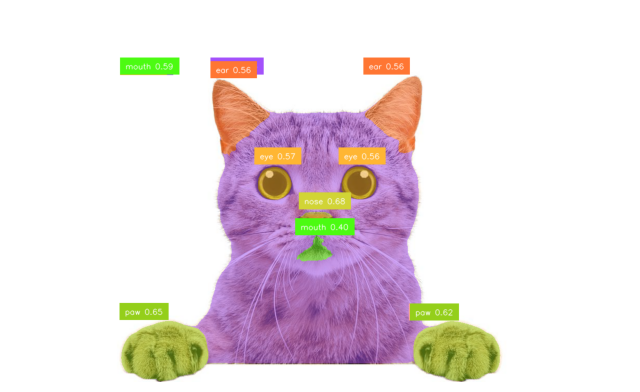

----------------------------------------------------------------------------------------------------
Post-processing of masks


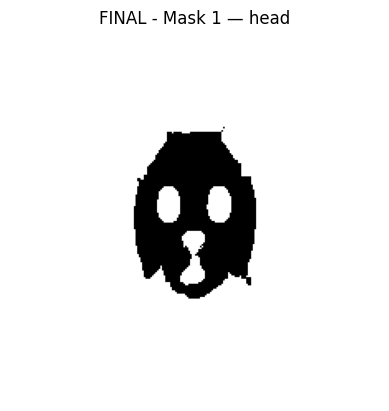

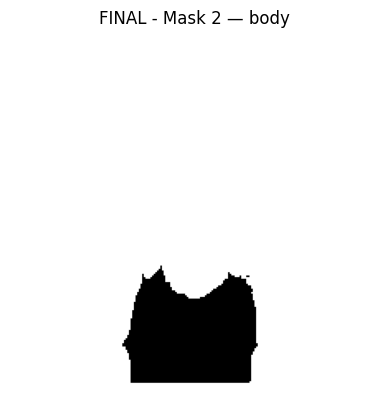

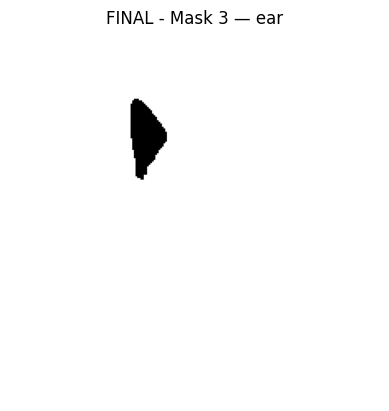

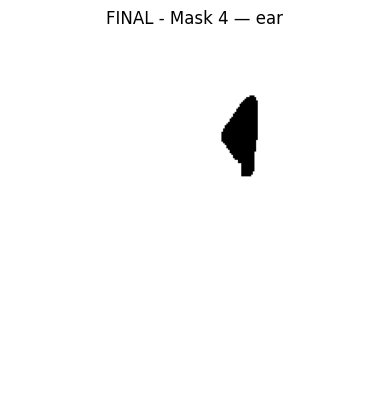

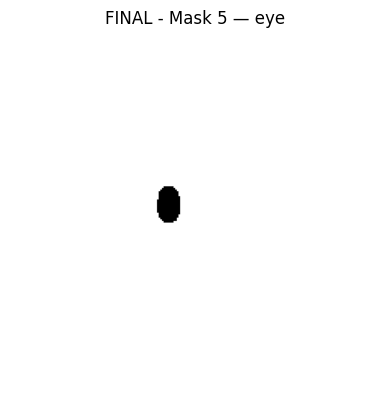

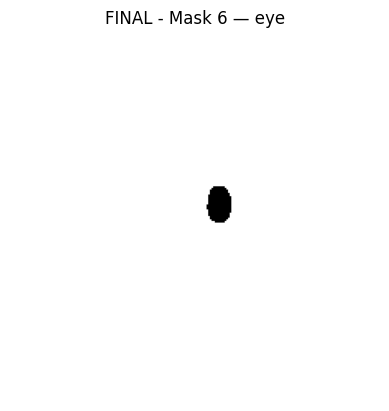

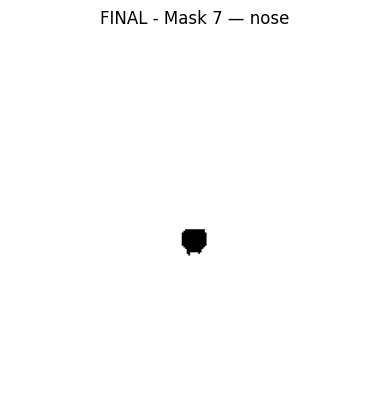

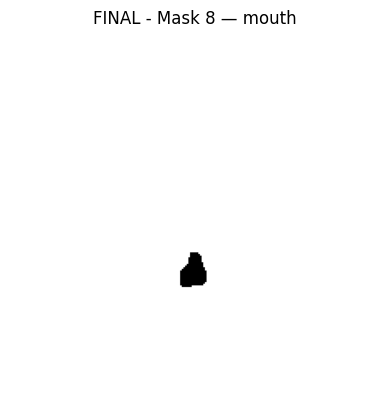

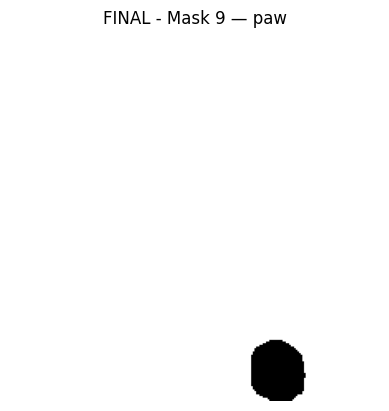

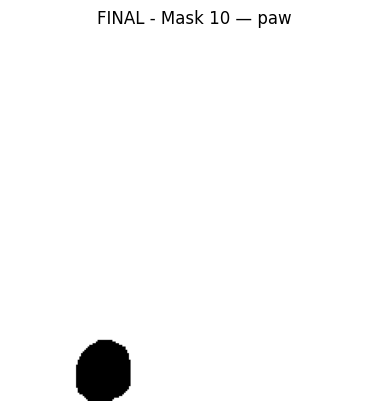

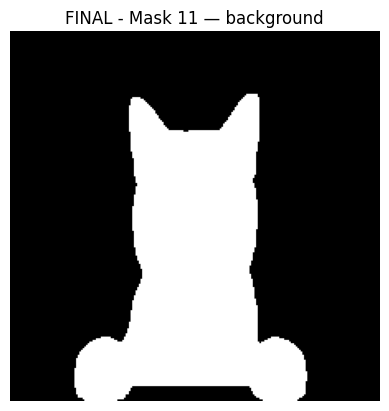

Final masks for this instance are: 11
------------------------------------------------------------------------------------------
Computing Gradient methods


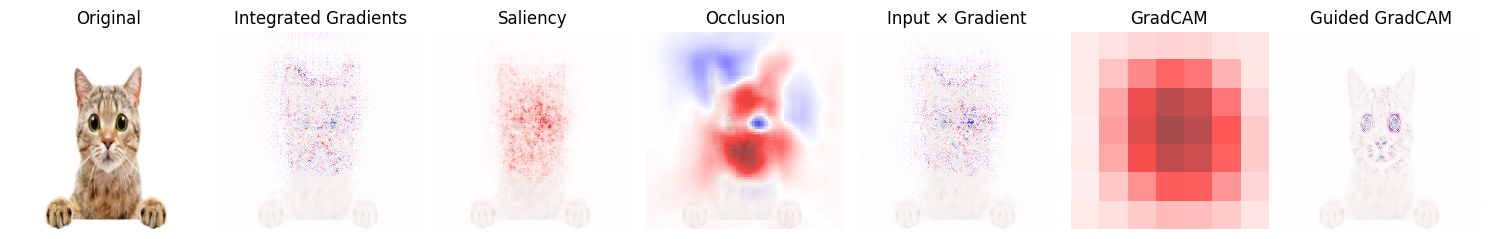

------------------------------------------------------------------------------------------
Computing LIME


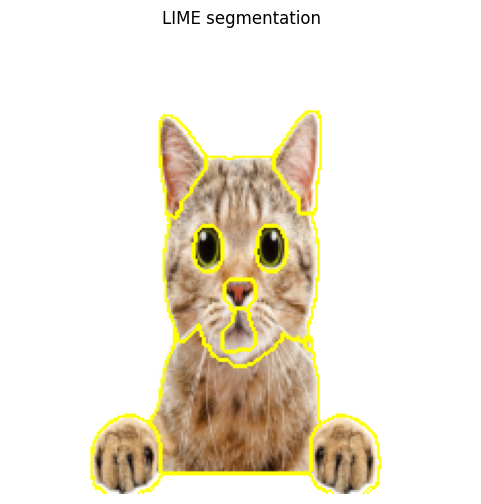

Feature IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Feature mask shape: (720, 1200)
Attribution range: -2.078644275665283 to 5.586700916290283


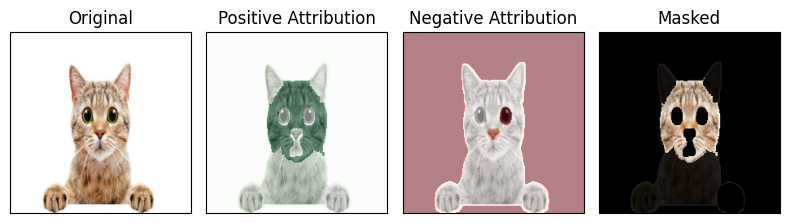

------------------------------------------------------------------------------------------
Computing SHAP


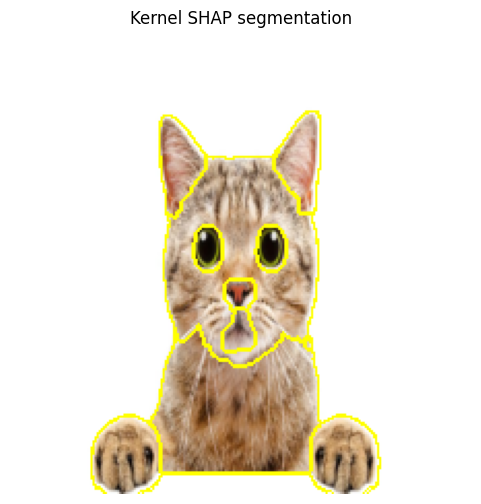

Attribution range: -1.223671 to 3.912621


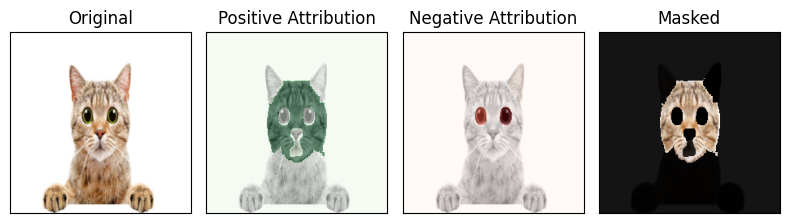

------------------------------------------------------------------------------------------
Feature Attributions


 Top masks by mean score for: Integrated Gradients
Rank 1: Mask 6 → Label: 'nose' | Score = 0.0065
Rank 2: Mask 2 → Label: 'ear' | Score = 0.0014
Rank 3: Mask 0 → Label: 'head' | Score = 0.0008
Rank 4: Mask 7 → Label: 'mouth' | Score = 0.0008
Rank 5: Mask 4 → Label: 'eye' | Score = 0.0002
Rank 6: Mask 10 → Label: 'background' | Score = -0.0000
Rank 7: Mask 9 → Label: 'paw' | Score = -0.0000
Rank 8: Mask 8 → Label: 'paw' | Score = -0.0001
Rank 9: Mask 1 → Label: 'body' | Score = -0.0001
Rank 10: Mask 3 → Label: 'ear' | Score = -0.0005
Rank 11: Mask 5 → Label: 'eye' | Score = -0.0073

 Top masks by mean score for: Saliency
Rank 1: Mask 5 → Label: 'eye' | Score = 0.0324
Rank 2: Mask 4 → Label: 'eye' | Score = 0.0188
Rank 3: Mask 6 → Label: 'nose' | Score = 0.0177
Rank 4: Mask 7 → Label: 'mouth' | Score = 0.0156
Rank 5: Mask 0 → Label: 'head' | Score = 0.0153
Rank 6: Mask 2 → L

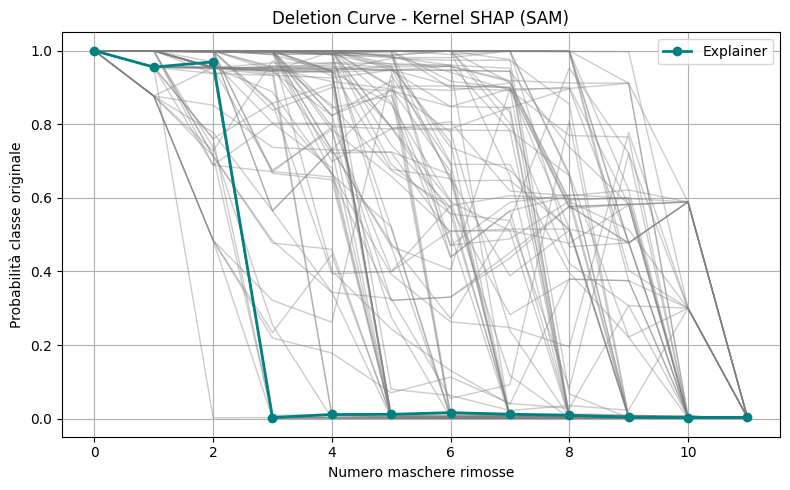

------------------------------------------------------------------------------------------
Computing Instability
 Run 1/10
 Run 2/10
 Run 3/10
 Run 4/10
 Run 5/10
 Run 6/10
 Run 7/10
 Run 8/10
 Run 9/10
 Run 10/10

 Sufficiency Score for each method:

 Method: Integrated Gradients
 Sufficiency Score = 1.0000

 Method: Saliency
 Sufficiency Score = 1.0000

 Method: Occlusion
 Sufficiency Score = 1.0000

 Method: Input × Gradient
 Sufficiency Score = 1.0000

 Method: GradCAM
 Sufficiency Score = 1.0000

 Method: Guided GradCAM
 Sufficiency Score = 1.0000

 Method: LIME (SAM)
 Sufficiency Score = 0.9890

 Method: Kernel SHAP (SAM)
 Sufficiency Score = 0.9921
------------------------------------------------------------------------------------------
Computing Valley Score
Valley Score (Kernel SHAP (SAM)): 0.6607


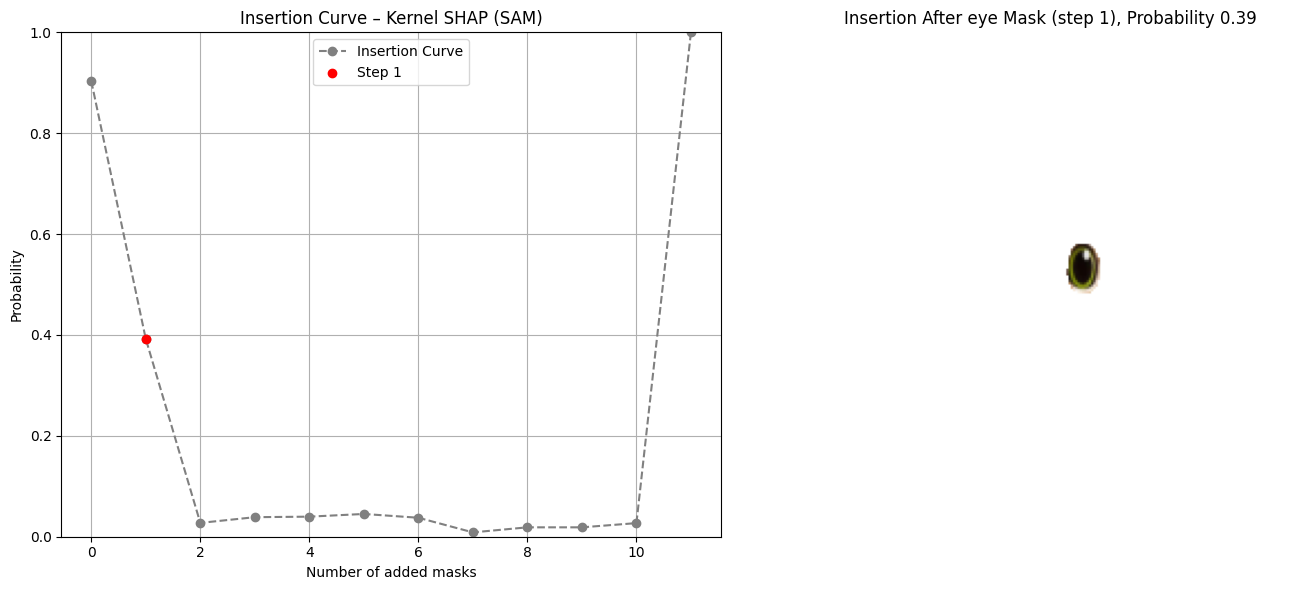

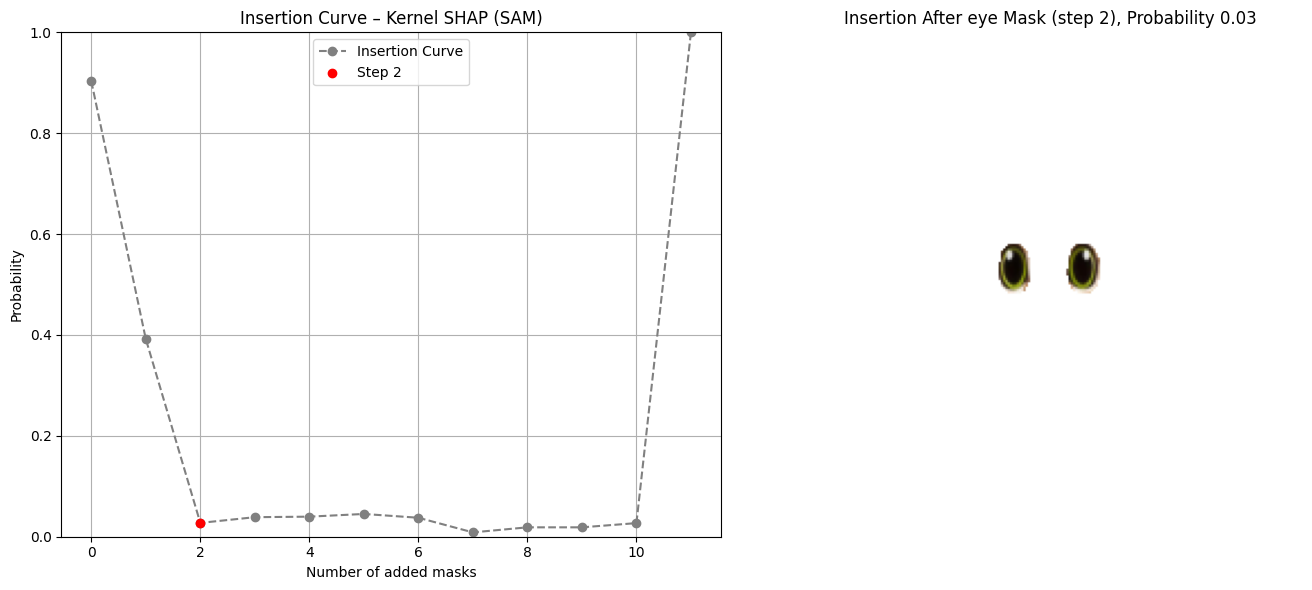

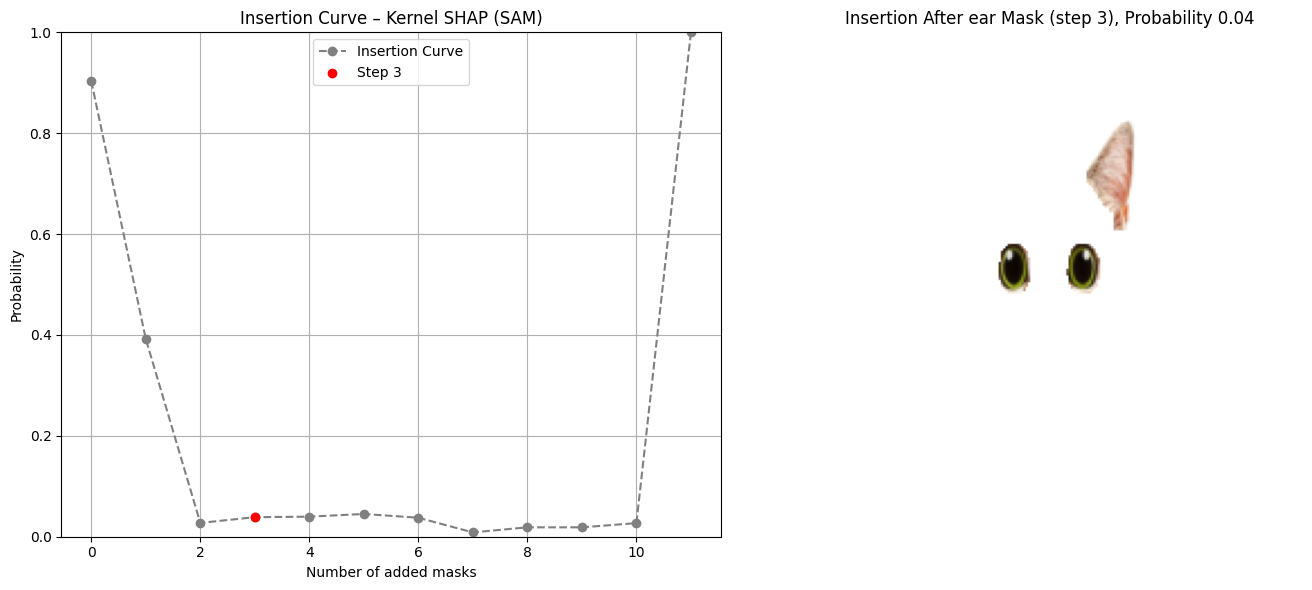

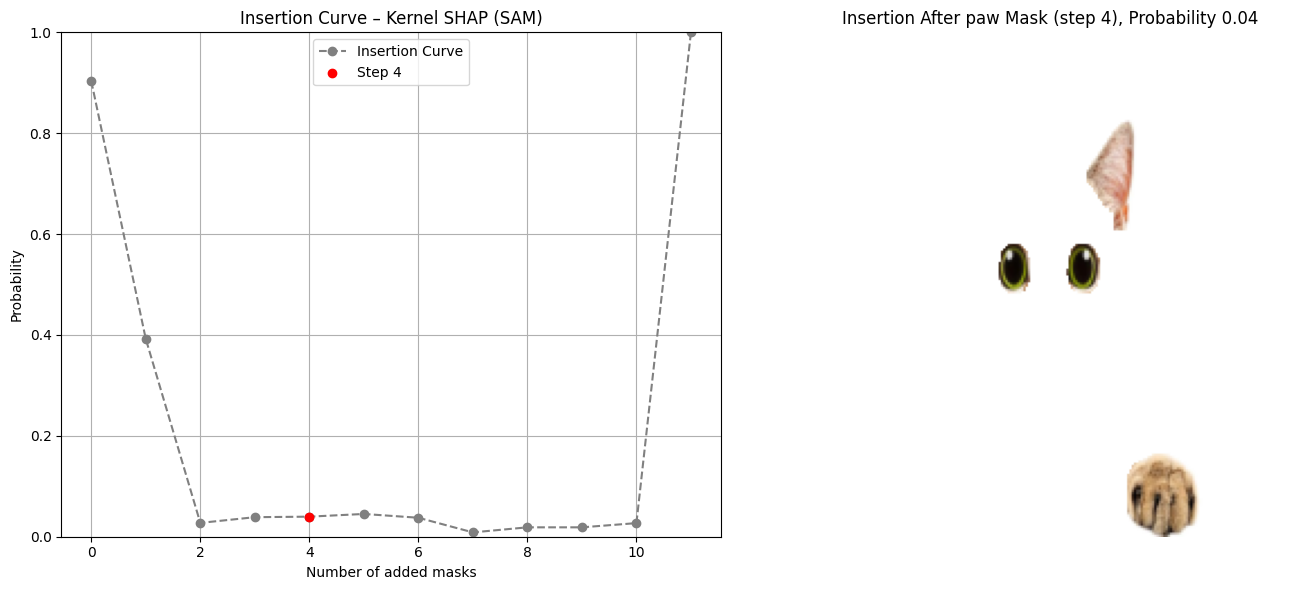

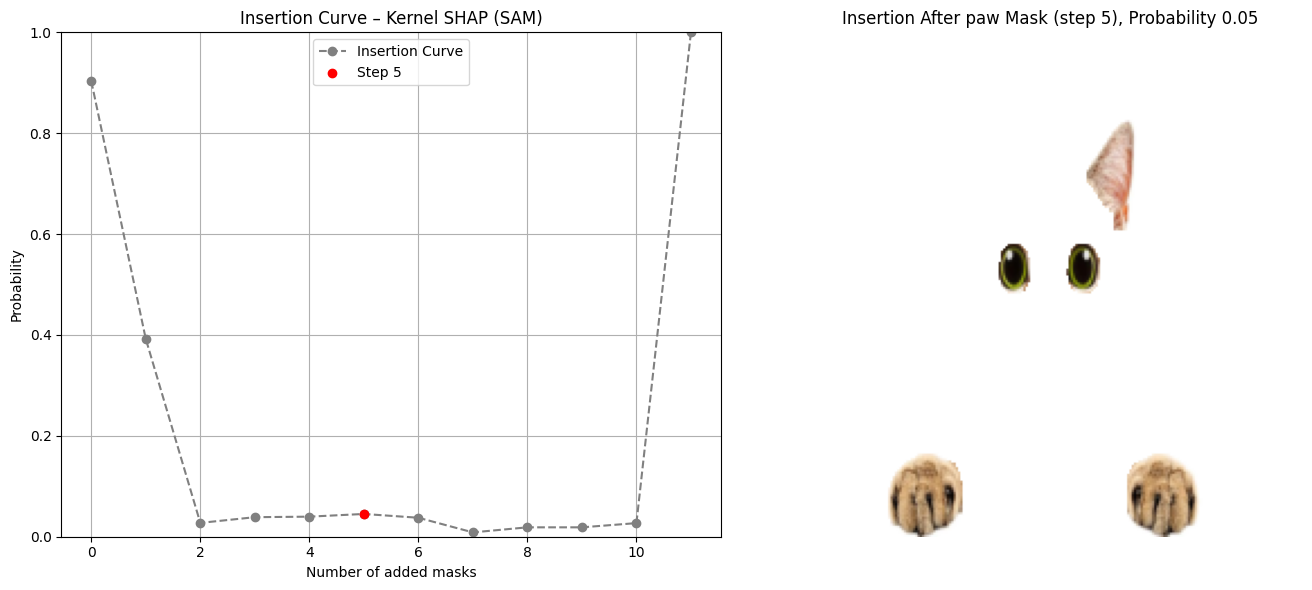

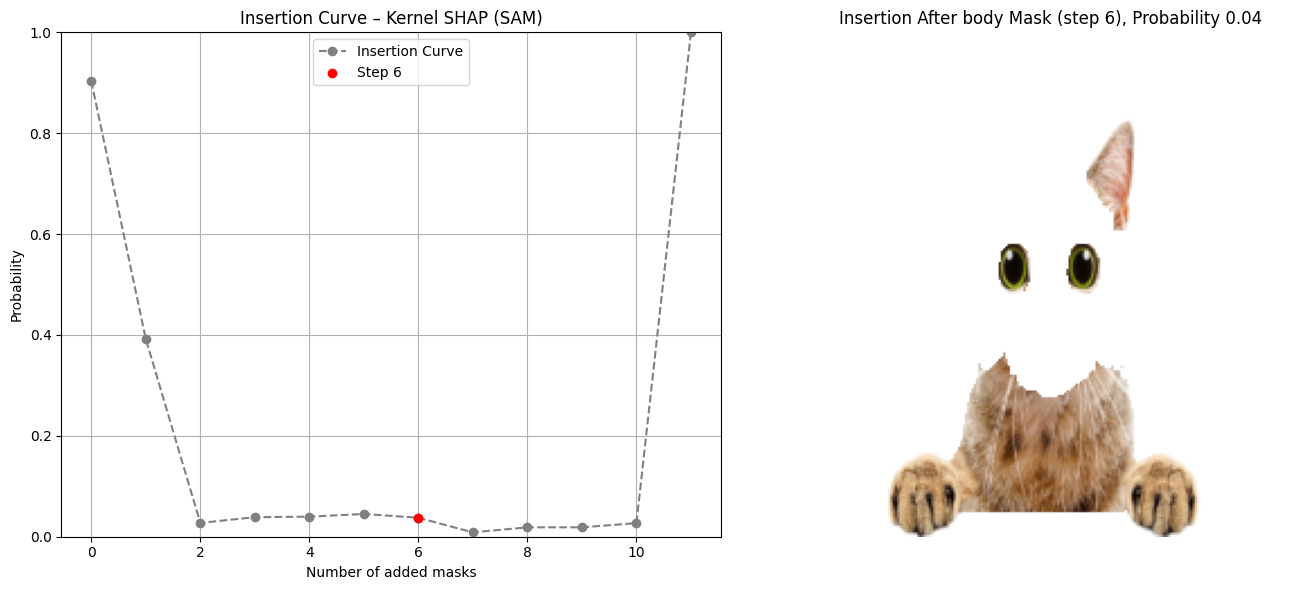

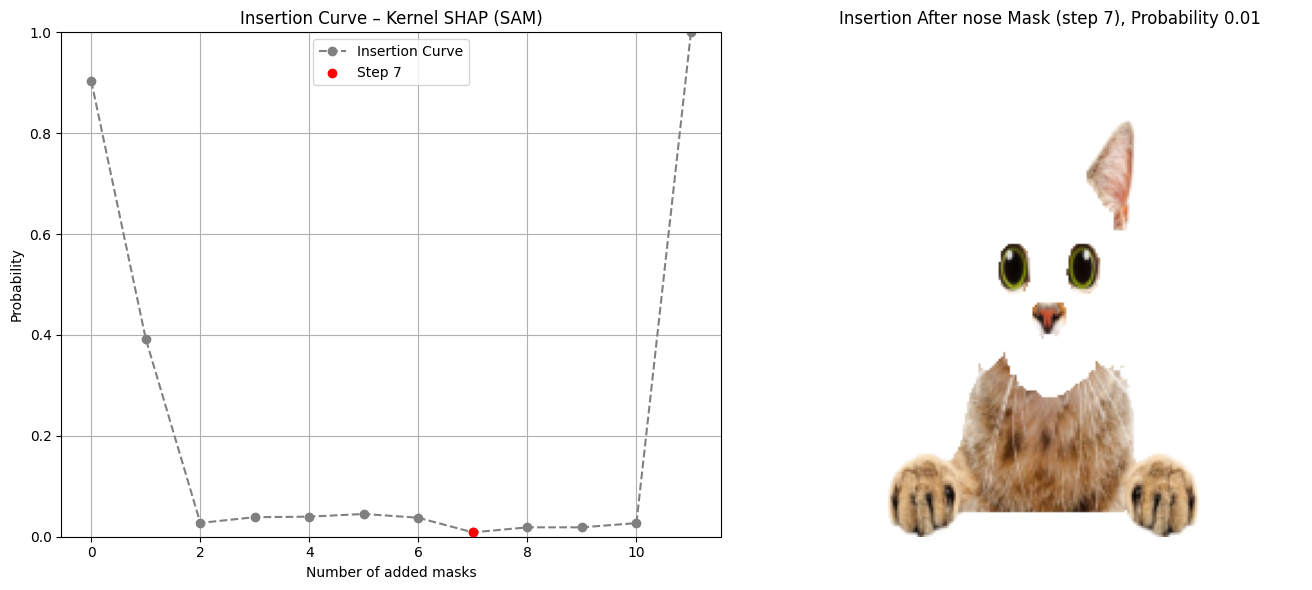

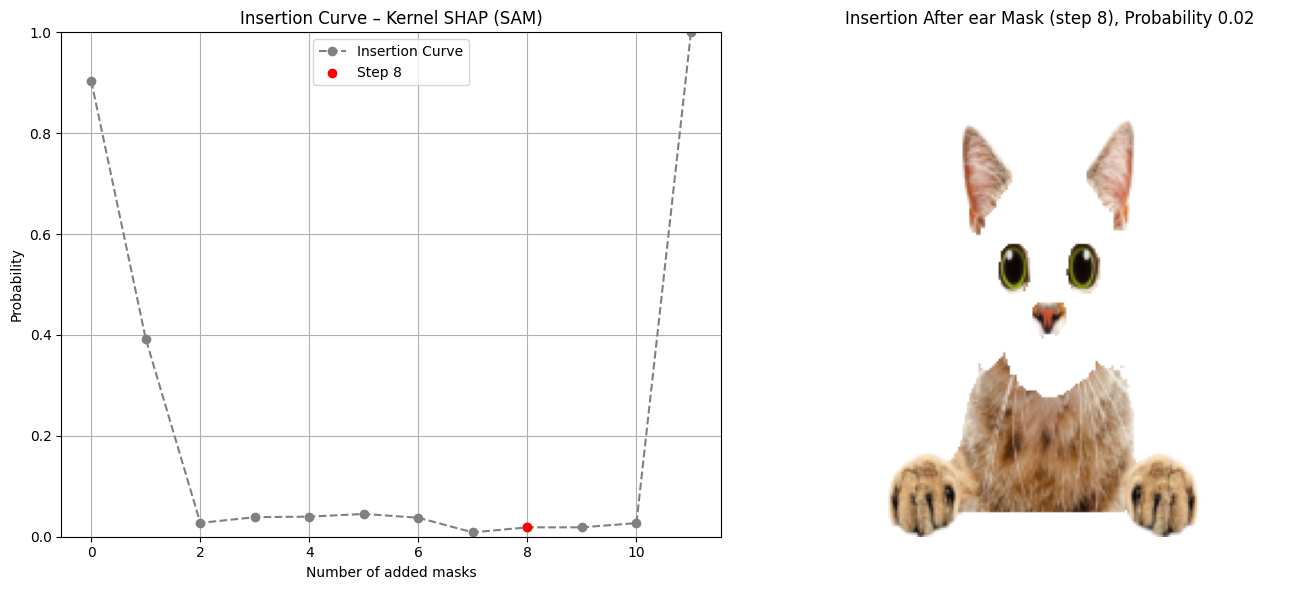

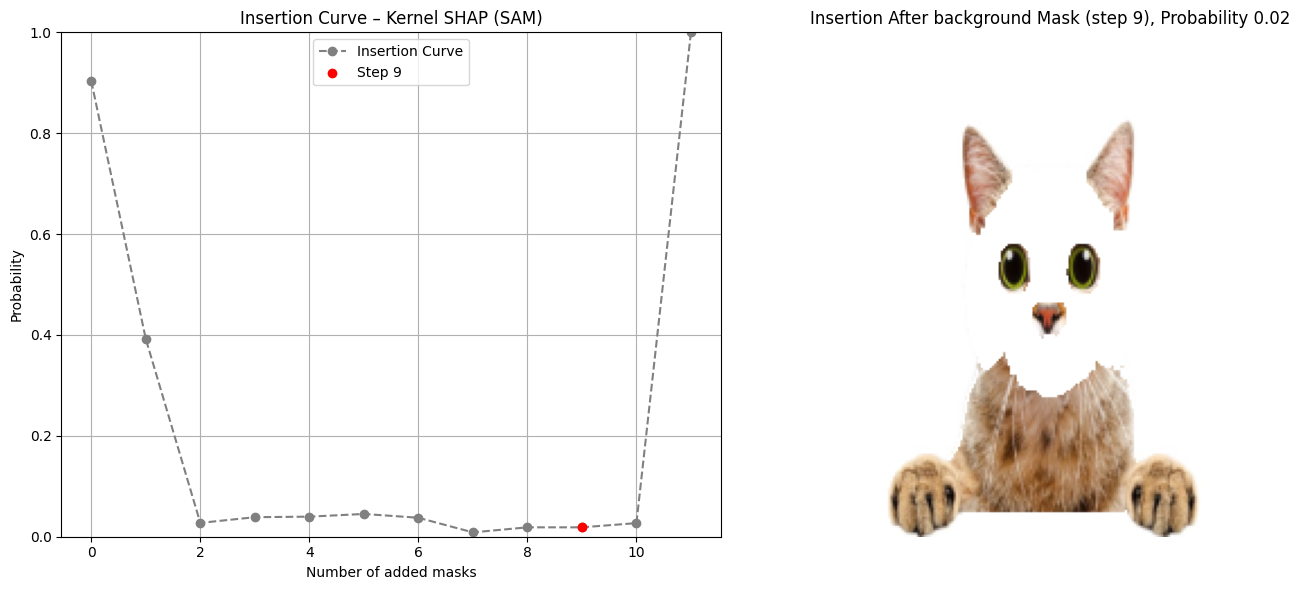

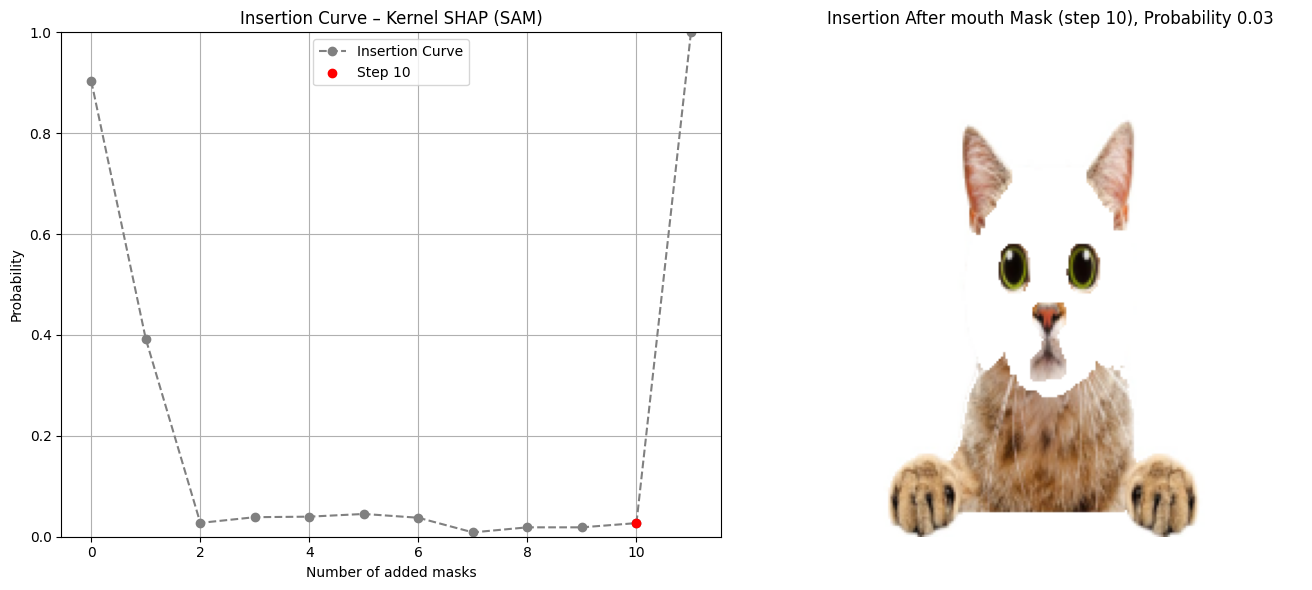

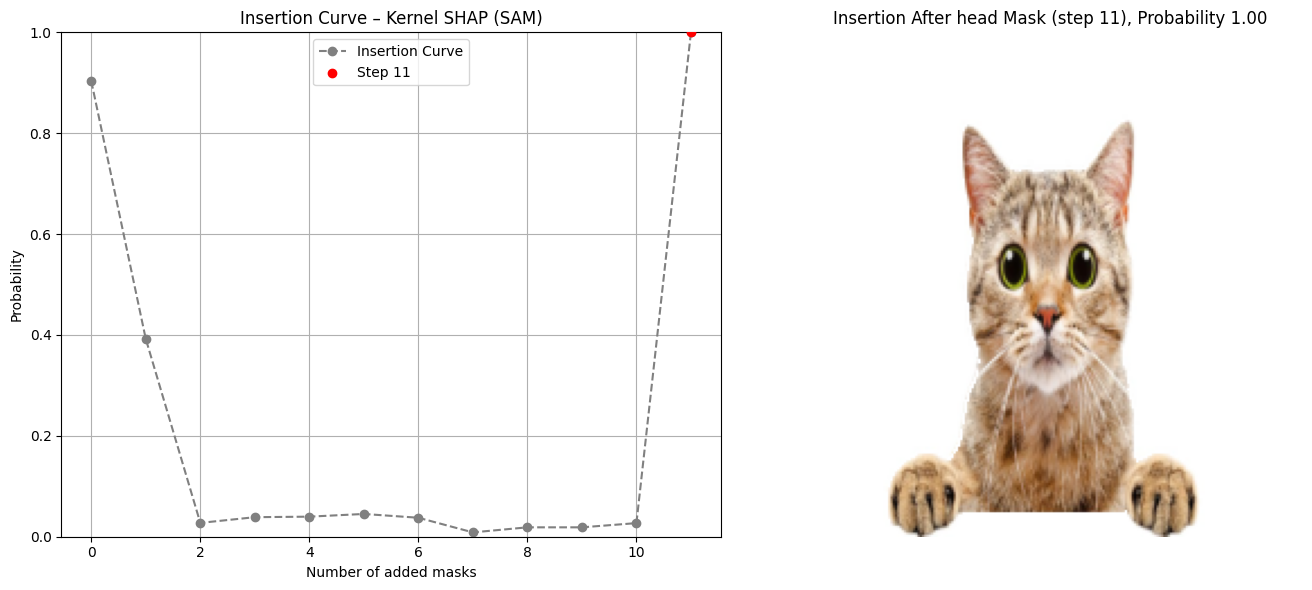

AUC: 0.1459
------------------------------------------------------------------------------------------
Computing Sufficiency
[Occlusion] P(full) = 0.9999 | P(EC-mask) = 0.9999 → Δ = -0.0000


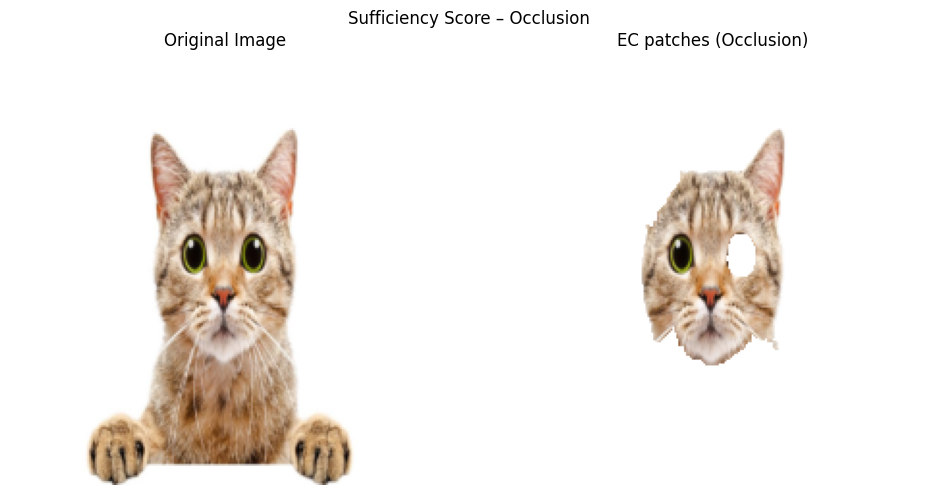

In [91]:
import torch
from torchvision import models
from torch import nn
import numpy as np
import cv2
from PIL import Image 
import matplotlib.pyplot as plt
import pandas as pd


model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("/kaggle/input/pre-computations/best_model.pth"))
model = model.to(device).eval()
# Inference
model.eval()

#ALL SHOW SETUPS
count = 0
show_SAM = True
show_prediction = False
show_feature_removal = True
show_masks= True

if not isinstance(image, torch.Tensor):
    image = transform(PILImage.open(image_path).convert("RGB")).unsqueeze(0).to(device)


assigned_label = "cat" if predicted_class == 0 else "dog"

# Choose medoid whose class is the opposite w.r.t. model class prediction
medoid_class = "cat" if "dog" in assigned_label else "dog"

print("Grounded-SAM Output")
# Use the correct segmentation model based on prediction
if assigned_label == "cat":
    results = sam_cat.predict(image_path) # Get the segmentation masks
    id_to_label = sam_cat.ontology.classes() # Get the mask-id → label dictionary
    

    if show_SAM:
        plot(
            image=cv2.imread(image_path),
            classes=sam_cat.ontology.classes(),
            detections=results
        ) 
else:
    results = sam_dog.predict(image_path)# Get the segmentation masks
    id_to_label = sam_dog.ontology.classes() # Get the mask-id → label dictionary
    
    if show_SAM:
        plot(
            image=cv2.imread(image_path),
            classes=sam_dog.ontology.classes(),
            detections=results
        ) 

# Filter the masks in order to avoid duplicates and to make them complementary (no overlap)
print("-"*100)
print("Post-processing of masks")
filtered_final_masks, filtered_final_labels, id_to_label = calculate_filtered_masks(image_path, results, id_to_label, show_masks)

# Compute attributions for gradient-based methods, LIME and SHAP 
print("-"*90)
print("Computing Gradient methods")
if image.shape[-2:] != (224, 224):
    image = torch.nn.functional.interpolate(image, size=(224, 224), mode='bilinear', align_corners=False)

attributions, method_to_duration = compute_gradient_methods(model, image, predicted_class, use_absolute=False, show=True)
print("-"*90)
print("Computing LIME")
attr_lime, duration_lime = compute_LIME(model, image, predicted_class, filtered_final_masks, use_absolute=False, show=True)
print("-"*90)
print("Computing SHAP")
attr_shap, duration_shap = compute_SHAP(model, image, predicted_class, filtered_final_masks, use_absolute=False, show=True)
print("-"*90)


# Store in the main dictionary also lime and shap results
attributions["LIME (SAM)"] = attr_lime
attributions["Kernel SHAP (SAM)"] = attr_shap

method_to_duration["LIME (G-SAM)"] = duration_lime
method_to_duration["Kernel SHAP (G-SAM)"] = duration_shap

# Sort the masks based on their attributions density (decremental order)
print("Feature Attributions")
print()
sorted_masks_by_method = sort_masks(attributions, filtered_final_masks, filtered_final_labels, id_to_label, show=True)

# If true, it prints the step-by-step removal of patches
if show_feature_removal:
    feature_removal_visualization(image, sorted_masks_by_method, medoid_class, filtered_final_masks, id_to_label)

print("-"*90)
print("-"*90)
print("-"*90)
print()
print("Computing EC")
# Compute Effective Compactness for all the methods, considering the current data sample
method_to_ec = compute_EC(assigned_label, original_prob, sorted_masks_by_method, image, model, medoid_class, predicted_class, show = True)

print("-"*90)
print("Computing RQI")
# Compute RQI for all the methods, considering the current data sample
method_to_rqi = compute_RQI(image, model, original_prob, predicted_class, medoid_class, sorted_masks_by_method, show=True)

print("-"*90)
print("Computing Instability")
# Compute Instability for all the methods, considering the current data sample
method_to_instability = compute_instability(image, model, original_prob, predicted_class, filtered_final_masks, number_of_experiments=10, show = True)

print("-"*90)
print("Computing Valley Score")
method_to_valley_score = compute_valley_score(image, attributions, sorted_masks_by_method, model, filtered_final_masks, predicted_class, show=True)

print("-"*90)
print("Computing Sufficiency")
method_to_ssufficiency_score= compute_sufficiency_ec(attributions, sorted_masks_by_method, method_to_ec, model, filtered_final_masks, image, predicted_class, show=True)



if show_prediction:
    
    print(f"Predicted class: {assigned_label}")
    print(f"Opposite class (medoid): {medoid_class}")

    img_to_show = image[0].cpu().clone()  # (3, 224, 224)
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_to_show = img_to_show * std + mean 
    
    img_to_show = img_to_show.permute(1, 2, 0).numpy()
    img_to_show = np.clip(img_to_show, 0, 1)
    
    # Visualizza
    plt.imshow(img_to_show)
    plt.title(f"Predicted class: {assigned_label}")
    plt.axis("off")
    plt.show()
